# Homework06

Exercises to practice pandas, data analysis and regression

## Goals

- Understand the effects of pre-processing data
- Get familiar with the ML flow: encode -> normalize -> train -> evaluate
- Understand the difference between regression and classification tasks
- Build an intuition for different regression models

### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework.

In [59]:
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/data_utils.py

In [60]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import OrdinalEncoder

from data_utils import object_from_json_url
from data_utils import StandardScaler
from data_utils import LinearRegression, SGDRegressor
from data_utils import regression_error

### Load Dataset

Let's load up the full [ANSUR](https://www.openlab.psu.edu/ansur2/) dataset that we looked at briefly in [Week 02](https://github.com/DM-GY-9103-2024F-H/WK02).

This is the dataset that has anthropometric information about U.S. Army personnel.

In [61]:
# Load Dataset
ANSUR_FILE = "https://raw.githubusercontent.com/PSAM-5020-2025S-A/5020-utils/main/datasets/json/ansur.json"
ansur_data = object_from_json_url(ANSUR_FILE)

# Look at first 2 records
ansur_data[:2]

[{'age': 18,
  'gender': 'F',
  'height': 66,
  'weight': 135,
  'span': 1699,
  'stature': 1645,
  'ear': {'breadth': 30, 'length': 61, 'protrusion': 20},
  'foot': {'breadth': 97, 'length': 243},
  'hand': {'breadth': 78, 'length': 182, 'palm': 108},
  'head': {'height': 243, 'circumference': 557}},
 {'age': 30,
  'gender': 'M',
  'height': 68,
  'weight': 207,
  'span': 1749,
  'stature': 1715,
  'ear': {'breadth': 35, 'length': 63, 'protrusion': 17},
  'foot': {'breadth': 100, 'length': 252},
  'hand': {'breadth': 87, 'length': 184, 'palm': 114},
  'head': {'height': 238, 'circumference': 560}}]

#### Nested data

This is that *nested* dataset from Week 02.

# 🤔

Let's load it into a `DataFrame` to see what happens.

In [117]:
# Read into DataFrame
ansur_df = pd.DataFrame.from_records(ansur_data)
ansur_df.head()

,age,gender,height,weight,span,stature,ear,foot,hand,head
0,18,F,66,135,1699,1645,"{'breadth': 30, 'length': 61, 'protrusion': 20}","{'breadth': 97, 'length': 243}","{'breadth': 78, 'length': 182, 'palm': 108}","{'height': 243, 'circumference': 557}"
1,30,M,68,207,1749,1715,"{'breadth': 35, 'length': 63, 'protrusion': 17}","{'breadth': 100, 'length': 252}","{'breadth': 87, 'length': 184, 'palm': 114}","{'height': 238, 'circumference': 560}"
2,27,M,67,121,1684,1657,"{'breadth': 36, 'length': 59, 'protrusion': 24}","{'breadth': 92, 'length': 251}","{'breadth': 84, 'length': 180, 'palm': 103}","{'height': 239, 'circumference': 516}"
3,20,M,73,185,1878,1828,"{'breadth': 36, 'length': 60, 'protrusion': 21}","{'breadth': 104, 'length': 280}","{'breadth': 95, 'length': 201, 'palm': 124}","{'height': 270, 'circumference': 582}"
4,33,M,76,150,1977,1883,"{'breadth': 39, 'length': 65, 'protrusion': 27}","{'breadth': 101, 'length': 271}","{'breadth': 90, 'length': 194, 'palm': 113}","{'height': 254, 'circumference': 559}"



# 😓🙄

That didn't work too well. We ended up with objects in our columns.

Luckily, our `DataFrame` library has a function called [`json_normalize()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.json_normalize.html) that can help.

In [118]:
# Read into DataFrame
ansur_df = pd.json_normalize(ansur_data)
ansur_df.head()

,age,gender,height,weight,span,stature,ear.breadth,ear.length,ear.protrusion,foot.breadth,foot.length,hand.breadth,hand.length,hand.palm,head.height,head.circumference
0,18,F,66,135,1699,1645,30,61,20,97,243,78,182,108,243,557
1,30,M,68,207,1749,1715,35,63,17,100,252,87,184,114,238,560
2,27,M,67,121,1684,1657,36,59,24,92,251,84,180,103,239,516
3,20,M,73,185,1878,1828,36,60,21,104,280,95,201,124,270,582
4,33,M,76,150,1977,1883,39,65,27,101,271,90,194,113,254,559


Much better. `DataFrames` are magic.

#### Data Exploration

Before we start creating models, let's do a little bit of data analysis and get a feeling for the shapes, distributions and relationships of our data.

1. Print `min`, `max` and `average` values for all of the features.
2. Print `covariance` tables for `age`, `ear.length` and `head.circumference`.
3. Plot `age`, `ear.length` and `head.circumference` versus the $1$ *feature* that is most correlated to each of them.

Don't forget to *encode* and *normalize* the data.

In [64]:
# Work on Data Exploration here

### Encode non-numerical features
ansur_df = pd.get_dummies(ansur_df, columns=['gender'], drop_first=True) # Use dummy variable instead of ordinary variable because gender does not have order

## 1. Print min, max, avg
ansur_df.describe()

### Normalize all data
ansur_scaler = StandardScaler()
ansur_scaled = ansur_scaler.fit_transform(ansur_df)

## 2. Print Covariances
cov_matrix = ansur_scaled.cov()
print(cov_matrix)

## 3. Plot features most correlated to age, ear length and head circumference
print('AGE')
print(cov_matrix["age"].sort_values(ascending=False)[:5])
print('-----')
print('EAR LENGTH')
print(cov_matrix["ear.length"].sort_values(ascending=False)[:5])
print('-----')
print('HEAD CIRCUMFERENCE')
print(cov_matrix["head.circumference"].sort_values(ascending=False)[0:5])

                         age    height    weight      span   stature  \
age                 1.000179  0.029467  0.217017  0.064304  0.037972   
height              0.029467  1.000179  0.659590  0.869103  0.959988   
weight              0.217017  0.659590  1.000179  0.662828  0.682587   
span                0.064304  0.869103  0.662828  1.000179  0.899400   
stature             0.037972  0.959988  0.682587  0.899400  1.000179   
ear.breadth         0.187740  0.355310  0.361981  0.348283  0.365847   
ear.length          0.292098  0.421910  0.487481  0.401564  0.438604   
ear.protrusion     -0.009254  0.283853  0.242281  0.268229  0.289324   
foot.breadth        0.064993  0.662081  0.708759  0.681016  0.677517   
foot.length         0.048699  0.820186  0.688228  0.862806  0.844233   
hand.breadth        0.133830  0.712196  0.710663  0.731574  0.727613   
hand.length         0.104642  0.736264  0.599894  0.844382  0.761877   
hand.palm           0.120726  0.695159  0.591608  0.796280  0.72

### Interpretation

<span style="color:hotpink;">
Does anything stand out about these graphs? Or the correlations?<br>
Are correlations symmetric? Does the feature most correlated to ear length also have ear length as its most correlated pair?
</span>

- Since the features are standardized, we can see the covariance as if we were looking at a matrix of correlation coefficients, which surprised me.
- The correlations are symmetric and each variable has a covariance of 1.00 when paired with itself.

### Regression

Now, we want to create a regression model to predict `head.circumference` from the data.

From our [Week 06](https://github.com/PSAM-5020-2025S-A/WK06) notebook, we can create a regression model by following these steps:

1. Load dataset (done! 🎉)
2. Encode label features as numbers (done! ⚡️)
3. Normalize the data (done! 🍾)
4. Separate the outcome variable and the input features
5. Create a regression model using all features
6. Run model on training data and measure error
7. Plot predictions and interpret results
8. Run model on test data, measure error, plot predictions, interpret results

13.910571985204234
count    5600.000000
mean      570.062857
std        18.342818
min       502.000000
25%       557.000000
50%       570.000000
75%       582.000000
max       635.000000
Name: head.circumference, dtype: float64
count    5600.000000
mean      570.062857
std        11.954933
min       526.565840
25%       561.705769
50%       569.982055
75%       578.005406
max       628.392416
Name: head.circumference, dtype: float64


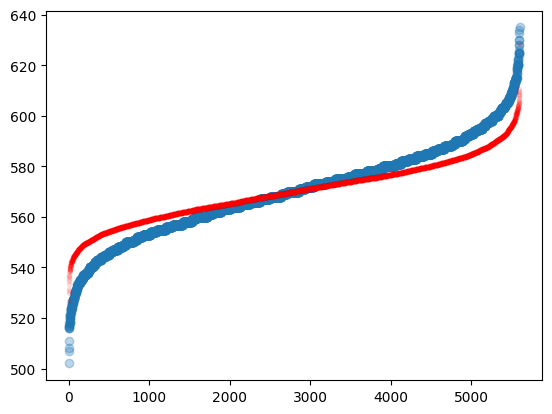

In [86]:
# Work on Regression Model here
ansur_scaler = StandardScaler()
ansur_scaled = ansur_scaler.fit_transform(ansur_df)

## Separate outcome variable and input features
head_circumference_scaled = ansur_scaled["head.circumference"]
ansur_features_scaled = ansur_scaled.drop(columns=['head.circumference'])

## Create a regression model
head_circum_model = LinearRegression()
head_circum_model.fit(ansur_features_scaled, head_circumference_scaled)
predicted_scaled = head_circum_model.predict(ansur_features_scaled)
predicted = ansur_scaler.inverse_transform(predicted_scaled)

## Measure error on training data
head_circum_original = ansur_df["head.circumference"]
head_circum_predicted = predicted["head.circumference"]
print(regression_error(head_circum_original, head_circum_predicted))

print(head_circum_original.describe())
print(head_circum_predicted.describe())

## Plot predictions and interpret results
plt.plot(sorted(head_circum_original), marker='o', linestyle='', alpha=0.3)
plt.plot(sorted(head_circum_predicted), color='r', marker='o', markersize='3', linestyle='', alpha=0.1)
plt.show()

In [87]:
## Load Test Data
ANSUR_TEST_FILE = "https://raw.githubusercontent.com/PSAM-5020-2025S-A/5020-utils/main/datasets/json/ansur-test.json"

ansur_test_data = object_from_json_url(ANSUR_TEST_FILE)
ansur_test_df = pd.json_normalize(ansur_test_data)
ansur_test_encoded_df = ansur_test_df.copy()

# Reindex
ansur_test_encoded_df = pd.get_dummies(ansur_test_df, columns=['gender'], drop_first=True)
ansur_test_encoded_df = ansur_test_encoded_df.reindex(columns=ansur_scaler.columns, fill_value=0)
ansur_test_scaled_df = ansur_scaler.transform(ansur_test_encoded_df)

14.473238058423496


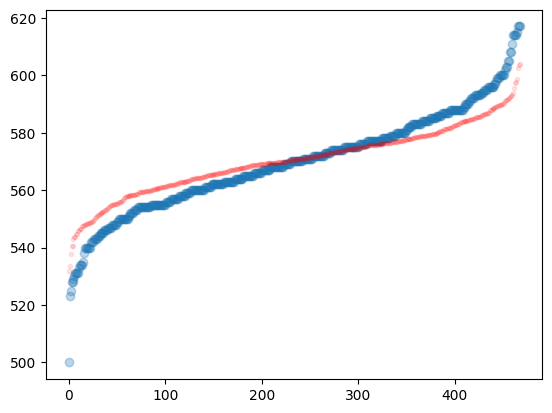

original --------------------
count    468.000000
mean     569.705128
std       17.676689
min      500.000000
25%      558.000000
50%      570.000000
75%      581.250000
max      617.000000
Name: head.circumference, dtype: float64
predict --------------------
count    468.000000
mean     570.251442
std       11.756635
min      531.925060
25%      562.821240
50%      570.603865
75%      577.654161
max      604.042820
Name: head.circumference, dtype: float64


In [111]:
## Run model on test data
ansur_test_features = ansur_test_scaled_df.drop(columns=['head.circumference'])
predicted_test_scaled = head_circum_model.predict(ansur_test_features)
predicted = ansur_scaler.inverse_transform(predicted_test_scaled)

## Plot predictions and interpret results
head_circum_original = ansur_test_df["head.circumference"]
head_circum_predicted = predicted["head.circumference"]

## Measure error on test data
print(regression_error(head_circum_original, head_circum_predicted))

# Plot the original and predicted prices
plt.plot(sorted(head_circum_original), marker='o', linestyle='', alpha=0.3)
plt.plot(sorted(head_circum_predicted), color='r', marker='o', markersize='3', linestyle='', alpha=0.1)
plt.show()

print("original --------------------")
print(head_circum_original.describe())

print("predict --------------------")
print(head_circum_predicted.describe())

### Interpretation

<span style="color:hotpink;">
How well does your model perform?<br>
How could you improve it?<br>
Are there ranges of circumferences that don't get predicted well?
</span>

- I thought this model was not bad because the error was only 14, which is relatively small considering the average is around 570.
- There is a tendency for the model to perform worse when predicting very large or very small values. Since we have already applied normalization to this dataset, I did not attribute this issue to outliers.
- As shown in the following cells, I attempted to improve the model’s accuracy by applying polynomial features in hopes of addressing this problem. While this approach performed well on the training data, it ultimately worsened accuracy on the test data, likely due to overfitting.

7.707110233218365


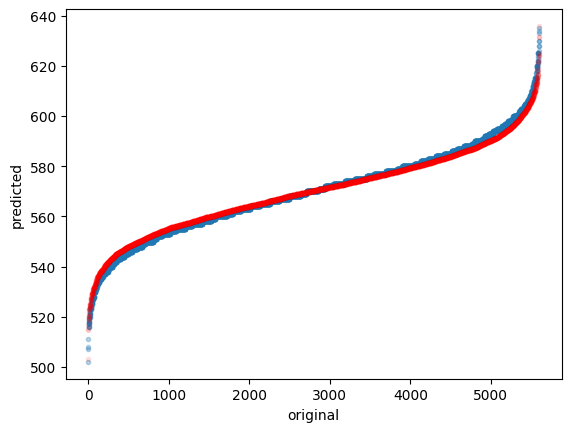

In [109]:
from data_utils import PolynomialFeatures

# make polynominal feature
poly = PolynomialFeatures(degree=4, include_bias=False)
features_poly = poly.fit_transform(ansur_features_scaled)

# create model
retry_head_circum_model = LinearRegression()
retry_head_circum_model.fit(features_poly, head_circumference_scaled)

predicted_test_scaled = retry_head_circum_model.predict(features_poly)
predicted = ansur_scaler.inverse_transform(predicted_test_scaled)

## Plot predictions and interpret results
head_circum_original = ansur_df["head.circumference"]
head_circum_predicted = predicted["head.circumference"]
print(regression_error(head_circum_original, head_circum_predicted))

## Plot predictions and interpret results
plt.plot(sorted(head_circum_original), marker='o', markersize='3', linestyle='', alpha=0.3)
plt.plot(sorted(head_circum_predicted), color='r', marker='o', markersize='3', linestyle='', alpha=0.1)
plt.ylabel("predicted")
plt.xlabel("original")
plt.show()

37.79995838254397


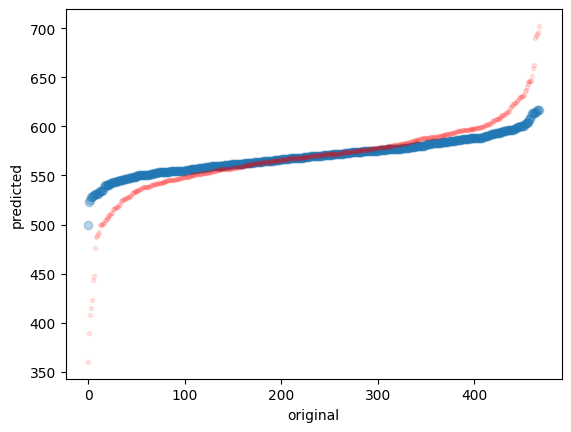

In [110]:
## Run model on test data
ansur_test_features = ansur_test_scaled_df.drop(columns=['head.circumference'])
test_features_poly = poly.fit_transform(ansur_test_features)
retry_predicted_test_scaled = retry_head_circum_model.predict(test_features_poly)
predicted = ansur_scaler.inverse_transform(retry_predicted_test_scaled)

## Plot predictions and interpret results
head_circum_original = ansur_test_df["head.circumference"]
head_circum_predicted = predicted["head.circumference"]

## Measure error on test data
print(regression_error(head_circum_original, head_circum_predicted))

# Plot the original and predicted prices
plt.plot(sorted(head_circum_original), marker='o', linestyle='', alpha=0.3)
plt.plot(sorted(head_circum_predicted), color='r', marker='o', markersize='3', linestyle='', alpha=0.1)
plt.ylabel("predicted")
plt.xlabel("original")
plt.show()